# Balancing Imbalanced Classes

Despite tuning random forests previously, the model is still very inaccurate at identifying functional water points that require repair, due to the low number of data records for this class. Here, we will use upsampling to balance classes to generate a random forest model with better recall and precision.

In [70]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import math
import re
from scipy import stats
from sklearn import preprocessing

import itertools
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.utils import resample
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score


In [2]:
# Code taken from sklearn: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [46]:
data = pd.read_csv('model_data1.csv')


In [49]:
# Prepare original data

# Isolate Dependent Variable
well = data['status_group']
# Isolate Independent Variable
predictors = data.drop(['status_group', 'id', 'Unnamed: 0', 'Unnamed: 0.1', 'amount_tsh', 'gps_height'], axis=1)
# Split into training and test sets
x_train, x_test, y_train, y_test = train_test_split(predictors, well, test_size = 0.25, random_state = 0)

In [50]:
predictors.columns.tolist()

['longitude',
 'latitude',
 'population',
 'amount_tsh_rob',
 'gps_height_rob',
 'basin_Internal',
 'basin_Lake Nyasa',
 'basin_Lake Rukwa',
 'basin_Lake Tanganyika',
 'basin_Lake Victoria',
 'basin_Pangani',
 'basin_Rufiji',
 'basin_Ruvuma / Southern Coast',
 'basin_Wami / Ruvu',
 'extraction_type_class_gravity',
 'extraction_type_class_handpump',
 'extraction_type_class_motorpump',
 'extraction_type_class_other',
 'extraction_type_class_rope pump',
 'extraction_type_class_submersible',
 'extraction_type_class_wind-powered',
 'funder_type_Nonprofit/NGO/Foundation',
 'funder_type_Other Govt/Govt Body',
 'funder_type_Private Company',
 'funder_type_Religious Organization',
 'funder_type_Tanzania Government',
 'funder_type_Tanzania Organization',
 'funder_type_other',
 'installer_final_ACRA',
 'installer_final_ADRA',
 'installer_final_Amref',
 'installer_final_CES',
 'installer_final_DA',
 'installer_final_DANIDA',
 'installer_final_DMDD',
 'installer_final_DWE',
 'installer_final_Distri

Upsample Minority Classes:

In [23]:
data2 = pd.read_csv('water4_scaled.csv')

# Divide the data into its respective classes
data_functional = data2[data2['status_group']=='functional']
data_repair = data2[data2['status_group']=='functional needs repair']
data_nonfunc = data2[data2['status_group']=='non functional']

In [24]:
# Upsample both non functional and water points needing repair
data_repair_upsample = resample(data_repair, replace = True, 
                                n_samples=data_functional.shape[0], 
                                random_state=123)

data_nonfunc_upsample = resample(data_nonfunc, replace = True, 
                                n_samples=data_functional.shape[0], 
                                random_state=123)

In [25]:
data_sampled = pd.concat([data_functional, data_repair_upsample, data_nonfunc_upsample])

In [26]:
# Check distribution of data
data_sampled['status_group'].value_counts()

functional                 32259
functional needs repair    32259
non functional             32259
Name: status_group, dtype: int64

In [27]:
data2 = data_sampled.drop(['wpt_name', 'subvillage', 'region_code', 'district_code', 'recorded_by', 'scheme_management',
                  'scheme_name', 'extraction_type', 'payment', 'water_quality', 'quantity_group', 'source', 
                  'waterpoint_type_group', 'installer_group', 'installer', 'funder',
                  'date_recorded', 'amount_tsh', 'gps_height','extraction_type_group', 
                  'construction_year', 'num_private', 'lga', 'ward'], axis=1)

data2 = data2[data2['permit'].isnull()==False]
data2 = data2[data2['public_meeting'].isnull()==False]

In [28]:
data2.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'id', 'longitude', 'latitude', 'basin',
       'region', 'population', 'public_meeting', 'permit',
       'extraction_type_class', 'management', 'management_group',
       'payment_type', 'quality_group', 'quantity', 'source_type',
       'source_class', 'waterpoint_type', 'status_group', 'funder_type',
       'installer_final', 'year', 'month-year', 'amount_tsh_rob',
       'gps_height_rob'],
      dtype='object')

In [29]:
data2 = pd.get_dummies(data2, columns=['basin', 'extraction_type_class', 'funder_type', 'installer_final', 
                                       'management', 'management_group', 'month-year', 'payment_type',
                                       'permit', 'public_meeting', 'region', 'source_class', 'source_type', 
                                       'waterpoint_type', 'year', 'quality_group', 'quantity']) 

In [39]:
well2 = data2['status_group']

In [38]:
predictors2 = data2.drop(['status_group', 'id', 'Unnamed: 0', 'Unnamed: 0.1'], axis=1)

In [40]:
# Split into training and test sets
x_train2, x_test2, y_train2, y_test2 = train_test_split(predictors2, well2, test_size = 0.25, random_state = 0)

In [41]:
# Fit Random Forest
clf10 = RandomForestClassifier(max_depth=40, max_features=30, min_samples_leaf=2, n_estimators=13) # max features set to sqrt(164 features)
clf10 = clf10.fit(x_train2, y_train2)


In [51]:
# How well does the random forest built with upsampled data predict outcomes for the original test sample that was not upsampled?
y_pred10b = clf10.predict(x_test)

In [52]:
f1_score(y_test, y_pred10b, average='weighted')

0.8922855526110649

Normalized confusion matrix
[[ 0.89047488  0.05888004  0.05064507]
 [ 0.00505561  0.99292214  0.00202224]
 [ 0.10265557  0.02952834  0.86781609]]


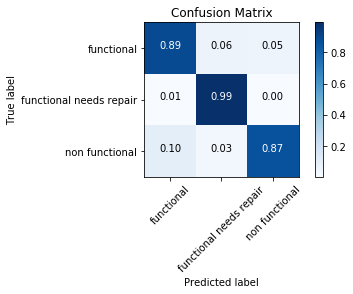

In [53]:
plt.figure()
plot_confusion_matrix(confusion_matrix(y_test, y_pred10b), 
                      classes=['functional', 'functional needs repair', 'non functional'],
                      normalize=True,
                      title = 'Confusion Matrix')

Upsampling has greatly increased recall for "non functional" and "functional needs repair" water points. However, the 99% recall rate for "functional needs repair" suggests overfitting. 

In [63]:
# Try cross validation

from sklearn.metrics.scorer import make_scorer
# Make scorer
f1_score_obj = make_scorer(f1_score, average='weighted')

In [66]:
scores = cross_val_score(clf10, x_train2, y_train2, cv=10)

In [68]:
scores.mean()

0.87885770448746303

In [72]:
# Using Grid Search

clf = RandomForestClassifier()

parameters = {"max_depth": [10, 30, 40],
               "n_estimators": [13, 30, 40],
               "min_samples_leaf": [2],
               "max_features": [20, 30, 40]}

rf_gridcv1 = GridSearchCV(estimator=clf, param_grid=parameters, n_jobs=1, cv = 5, 
                         verbose=100)

In [ ]:
rfgridfit1 = rf_gridcv1.fit(x_train2, y_train2)

In [74]:
rfgridfit1.best_score_

0.88148592155416206

In [75]:
rfgridfit1.best_params_

{'max_depth': 40,
 'max_features': 40,
 'min_samples_leaf': 2,
 'n_estimators': 40}

In [82]:
# Fit Random Forest
# Try max features of None to see if we can further increase f1 score
clf11 = RandomForestClassifier(max_depth=40, max_features=None, min_samples_leaf=2, n_estimators=13) # max features set to sqrt(164 features)
clf11 = clf11.fit(x_train2, y_train2)

In [83]:
# How well does the random forest built with upsampled data predict outcomes for the original test sample that was not upsampled?
y_pred10c = clf11.predict(x_test)

In [84]:
f1_score(y_test, y_pred10c, average='weighted')

0.91233777056301557

Normalized confusion matrix
[[ 0.91929728  0.04309635  0.03760637]
 [ 0.00303337  0.99494439  0.00202224]
 [ 0.09235038  0.02596116  0.88168847]]


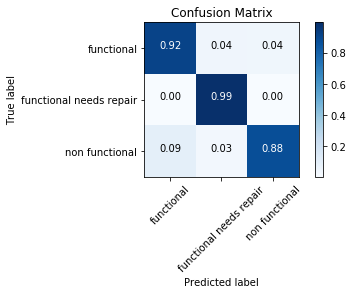

In [85]:
plt.figure()
plot_confusion_matrix(confusion_matrix(y_test, y_pred10c), 
                      classes=['functional', 'functional needs repair', 'non functional'],
                      normalize=True,
                      title = 'Confusion Matrix')